In [19]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from collections import Counter

from pygln import utils
# from pygln.pytorch import GLN
# from sklearn.metrics import accuracy_score

# TODO: Implement this context function evaluation in GLN code
# TODO: Cumulative context function distribution plots
# TODO: Test context functions with original vs. deskewed MNIST

In [20]:
class ContextPlots():
    def __init__(self, deskew=True):
        if deskew:
            print('Loading/deskewing MNIST')
            self.X_train = np.load('X_train.npy')
            self.y_train = np.load('y_train.npy')
            self.X_test = np.load('X_test.npy')
            self.y_test = np.load('y_test.npy')
        else:
            print('Loading MNIST without deskewing')
            self.X_train, self.y_train, self.X_test, self.y_test = utils.get_mnist(deskewed=False)

        self.num_neurons = 4
        self.num_subcontexts = 4
        self.num_ctx = 2**self.num_subcontexts
        self.boolean_converter = torch.nn.Parameter(torch.tensor([[2**i] for i in range(self.num_subcontexts)]),
                                            requires_grad=False)

        self.context_maps = torch.randn(size=(self.num_neurons, self.num_subcontexts, self.X_train.shape[1]),
                                dtype=torch.float32)

        # self.gating_dist: [self.num_neurons, self.num_subcontexts, num_samples]
        self.gating_dist = torch.einsum('abc,dc->abd', self.context_maps, torch.tensor(self.X_train).float())
        self.gating_output = (self.gating_dist > 0).int()
        self.context_idx = torch.sum(self.gating_output * self.boolean_converter, dim=-2)
    
    def permute_by_freq(self, x):
        x = x.numpy()
        most_common = Counter(x).most_common()
        by_freq = [i[0] for i in most_common]
        permute_dict = dict(zip(by_freq, range(self.num_ctx)))
        permuted_list = np.array([permute_dict[i] for i in x])
        return permuted_list

    def multiple_neurons(self):
        # Cumulative distributions of multiple neurons/sets of contexts overlaid on same plot
        fig, ax = plt.subplots(figsize=(8, 4))

        # Add plot for each neuron
        for n in range(self.context_idx.shape[0]):  # For each neuron
            sorted_ctx_list = self.permute_by_freq(self.context_idx[n])
            ax.hist(sorted_ctx_list, bins=range(self.num_ctx), histtype='step',
                    cumulative=True, label='Neuron {}'.format(n+1))

        ax.legend(loc='lower right')
        ax.set_title('Cumulative histograms of contexts for {} neurons'.format(self.num_neurons))
        ax.set_xlabel('Context in GLN neuron')
        ax.set_ylabel('Sample in dataset')
        plt.show()

    def single_neuron_by_class(self):
        # Cumulative plot of single neuron/set of contexts with columns colored by class
        fig, ax = plt.subplots(figsize=(8, 4))

        sorted_ctx_list = self.permute_by_freq(self.context_idx[0])
        labels = np.unique(self.y_train)
        ctx_lists_by_class = [[] for i in labels]
        for i, ctx in enumerate(sorted_ctx_list):
            ctx_idx = np.where(labels == self.y_train[i])
            ctx_lists_by_class[ctx_idx[0][0]].append(ctx)

        ax.hist(ctx_lists_by_class, bins=range(self.num_ctx), histtype='barstacked',
                cumulative=True, label=labels)

        ax.legend(loc='lower right')
        ax.set_title('Cumulative histogram of contexts for single neuron by class'.format(self.num_neurons))
        ax.set_xlabel('Context in GLN neuron')
        ax.set_ylabel('Sample in dataset')
        plt.show()

    def multiple_neurons_and_contexts():
        # Cumulative plot of distribution with multiple neurons/sets of contexts
        # TODO: Does this even make sense if each neuron is assigned to a single context
        #       for each neuron?
        fig, ax = plt.subplots(figsize=(8, 4))

        # sorted_ctx_list = self.permute_by_freq(self.context_idx[0])
        return

Loading/deskewing MNIST


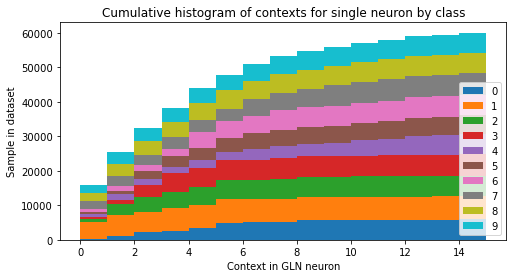

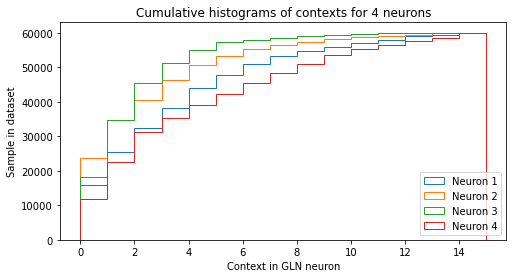

In [22]:
c = ContextPlots()
c.single_neuron_by_class()
c.multiple_neurons()

Loading MNIST without deskewing


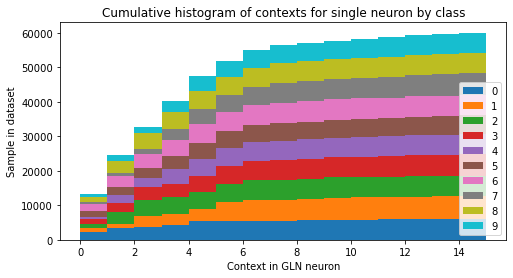

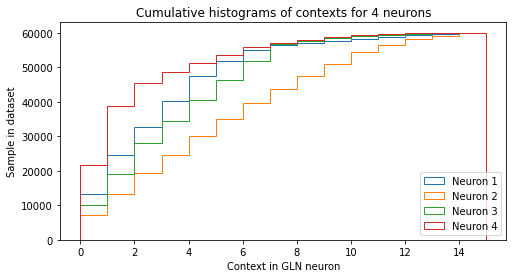

In [23]:
c = ContextPlots(deskew=False)
c.single_neuron_by_class()
c.multiple_neurons()